## Analysis of the experiments

### Steps:
- Hyper-parameter search -> individual `*.h5` file in `result/` == result of the search in `search/search.py`
- `eval/eval.py` -> evaluating the search from the results `result/*.h5` == result of the evaluation: `res.csv`
- Analysis of the evaluations: This notebook

### Contents:
1. Analyze the data
2. Plot the trends

### Goal: Analyze the hyperparameters, plot the trends
- Author: T. Slanináková, xslanin@fi.muni.cz
- Date: 2023-10-11

**Observed points / notes:**
- parameters with the highest impact on overall time: n. of categories (`cat`), n. of most similar buckets searched (`bucket`), maybe n. of epochs (`ep`)
- parameters with the lowest impact: `lr`, `model`

In [1]:
# pandas options
import warnings
import pandas as pd
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

to generate `res.csv`, run `python eval/eval.py`
- iterates through every experiment in `result/`, transforms it into a row in `res.csv`

## 1. Analyze the data
#### Load the `res.csv`

In [2]:
df = pd.read_csv('res.csv')
df.shape

(2088, 7)

In [3]:
df.head(2)

,data,size,algo,buildtime,querytime,params,recall
0,pca96v2,10M,Learned-index,22322.130576,216.556589,learned-index-pca96v2-10M-ep=212-lr=0.008-cat=122-model=MLP-buck=1-862353.elixir-pbs.elixir-czech.cz,0.67625
1,pca96v2,10M,Learned-index,5743.931219,669.535078,learned-index-pca96v2-10M-ep=55-lr=0.09-cat=122-model=MLP-buck=4-861285.elixir-pbs.elixir-czech.cz,0.88893


In [4]:
def process_dataframe(df):
    """ Parse info out of `params` columns. """
    df[[i for i in range(12)]] = df.params.str.split('-', expand=True)
    df = df.dropna()
    df['ep'] = df[4].str.split('=', expand=True)[1].astype(int)
    df['lr'] = df[5].str.split('=', expand=True)[1].astype(float)
    df['cat'] = df[6].str.split('=', expand=True)[1].astype(int)
    df['bucket'] = df[8].str.split('=', expand=True)[1].astype(int)
    df['jobid'] = df[9].str.split('.elixir', expand=True)[0].astype(int)
    # move `params` column to the back
    df.insert(df.shape[1]-1, 'params', df.pop('params'))
    df = df.drop([i for i in range(12)], axis=1)
    return df

In [5]:
df = process_dataframe(df)
df.head(2)

,data,size,algo,buildtime,querytime,recall,ep,lr,cat,bucket,jobid,params
0,pca96v2,10M,Learned-index,22322.130576,216.556589,0.67625,212,0.008,122,1,862353,learned-index-pca96v2-10M-ep=212-lr=0.008-cat=122-model=MLP-buck=1-862353.elixir-pbs.elixir-czech.cz
1,pca96v2,10M,Learned-index,5743.931219,669.535078,0.88893,55,0.090,122,4,861285,learned-index-pca96v2-10M-ep=55-lr=0.09-cat=122-model=MLP-buck=4-861285.elixir-pbs.elixir-czech.cz


In [6]:
# check out 5 fastest setups with recall higher than 90%
df.query('recall > 0.9').sort_values(by='querytime').head(3)

,data,size,algo,buildtime,querytime,recall,ep,lr,cat,bucket,jobid,params
1012,pca96v2,10M,Learned-index,29868.730211,519.733375,0.90273,205,0.009,123,4,862501,learned-index-pca96v2-10M-ep=205-lr=0.009-cat=123-model=MLP-buck=4-862501.elixir-pbs.elixir-czech.cz
783,pca96v2,10M,Learned-index,28440.693640,536.458194,0.91102,195,0.009,116,4,859473,learned-index-pca96v2-10M-ep=195-lr=0.009-cat=116-model=MLP-buck=4-859473.elixir-pbs.elixir-czech.cz
596,pca96v2,10M,Learned-index,31441.985064,545.397900,0.91156,220,0.009,122,4,859436,learned-index-pca96v2-10M-ep=220-lr=0.009-cat=122-model=MLP-buck=4-859436.elixir-pbs.elixir-czech.cz


#### Top 1 by data type, bucket size and n. of categories

In [7]:
df.query('recall > 0.9').groupby('data')['querytime'].min()

data
clip768v2    839.350932
pca32v2      693.058218
pca96v2      519.733375
Name: querytime, dtype: float64

In [8]:
df.query('recall > 0.9').groupby('bucket')['querytime'].min()

bucket
2     1714.350018
3      858.649798
4      519.733375
5      662.709375
6      693.058218
7      798.435510
8      820.391420
9     1035.096954
10    1019.145122
12    1226.541410
20    2793.372579
24    4235.687508
40    6628.313679
Name: querytime, dtype: float64

### Categories and query time

In [9]:
df.query('recall > 0.9').groupby('cat')['querytime'].min().to_frame().style.background_gradient(
    axis=1, subset=['querytime'], vmin=500, vmax=3000
)

,querytime
cat,
10,3158.084125
20,1714.350018
30,1671.673105
50,1054.538491
80,935.995593
90,888.100942
100,701.028996
105,777.112269
110,589.214696


## 2. Plot the trends

In [15]:
import matplotlib.pyplot as plt

def aggregate_data(df):
    return df \
        .query('recall > 0.9') \
        .groupby(['data', 'cat', 'bucket'])['querytime'] \
        .nsmallest(1) \
        .reset_index()

def plot(df, plot_type, save=False):
    fig = plt.figure(figsize=(8, 4))

    colors = [
        (170 / 255, 0 / 255, 120 / 255),
        (150 / 255, 225 / 255, 0 / 255),
        (106 / 255, 90 / 255, 205 / 255)
    ]
    datasets = sorted(df.data.unique().tolist())
    markers = ["o", "s", "D"]
    line_width = 2

    data = aggregate_data(df)
    
    for dataset_type_index in range(len(datasets)):
        datum = data.query(
            f'cat > 30 & querytime < 1300 & data == "{datasets[dataset_type_index]}"'
        ).reset_index(drop=True)

        categories = datum.cat.reset_index(drop=True).tolist()
        datum['avg_n_visited_objects'] = datum.bucket * (10_000_000 / datum.cat)
        n_visited_objects = datum.avg_n_visited_objects.reset_index(drop=True).tolist()
        querytime = datum.querytime.reset_index(drop=True).tolist()
        label = datasets[dataset_type_index].replace("v2", "")

        plt.plot(
            categories if plot_type == 'cat' else n_visited_objects,
            querytime,
            markers[dataset_type_index],
            color=colors[dataset_type_index],
            label=label,
            linewidth=line_width,
        )

    plt.xlabel('Number of categories')
    plt.ylabel('Query time (s)')
    plt.legend(framealpha=1)
    plt.grid(which="major", color="k", linestyle="-", linewidth=0.2)

    #plt.xticks([50, 75, 100, 125, 150, 175, 200])
    if plot_type != 'cat':
        plt.xticks(
            ticks=[i for i in range(300_000, 650_000, 50_000)],
            labels=[f'{str(i)[:-3]}k' for i in range(300_000, 650_000, 50_000)]
        )
    plt.yticks([600, 800, 1000, 1200])

    plt.tight_layout()
    
    if save:
        plt.savefig(f'{plot_type}.pdf')
    else:
        plt.show()

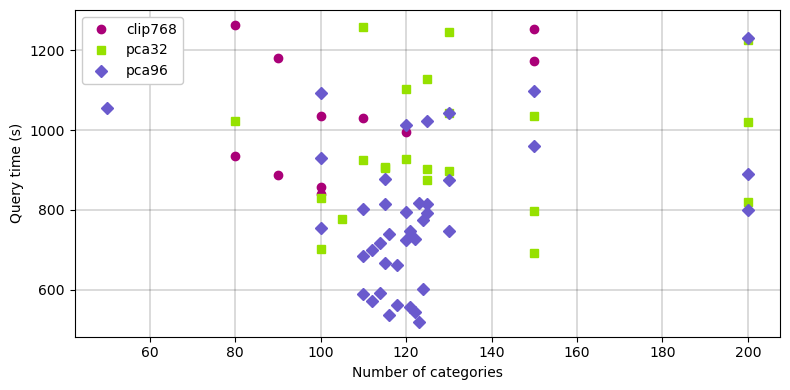

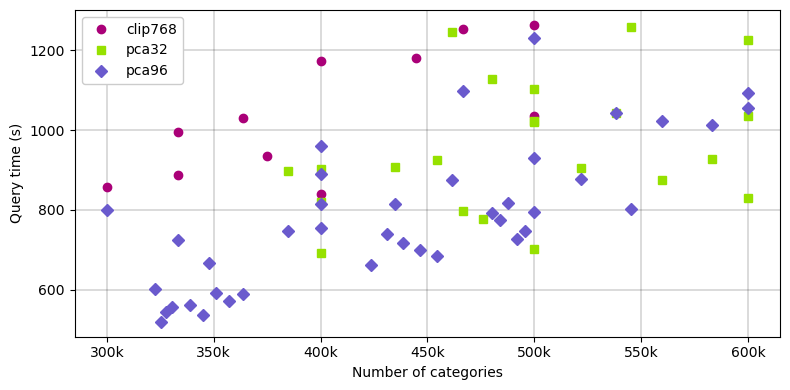

In [18]:
# plot and save both of the plots
plot(df, 'cat', save=True)
plot(df, 'nobjects', save=True)